In [25]:
from typing import Final

from models.base_llm import BaseLLM
from models.ollama_llm import OllamaLLM

from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import copy

from utils import join_names, insert_sentence_after_period
from utils.persistent import save_nl2sf, load_nl2sf, save_smcdel_sf, load_smcdel_sf, NameInfo
from models.openai_llm import OpenAILLM
from utils.prompt import get_prompt
from executors.smcdel import SMCDEL
import matplotlib.pyplot as plt

constants

In [26]:
model_name: Final[str] = "gpt-3.5-turbo"  # should be openai's model or ollama's model
random_state: Final[int] = 1
sample_size: Final[int] = 20

parameters

In [27]:
name_info: Final[NameInfo] = {
    "model_name": model_name,
    "random_state": random_state,
    "sample_size": sample_size
}

# Data

## 1. Load Data

In [28]:
dataset = load_dataset("sileod/mindgames", cache_dir='./data')
train = pd.DataFrame(dataset['train'])
val = pd.DataFrame(dataset['validation'])
test = pd.DataFrame(dataset['test'])

## 2. Data Exploration

data showcase

In [29]:
train.head(1)

,premise,smcdel_problem,n_announcements,pbcheck,hypothesis,setup,hypothesis_depth,n_agents,label,names,index,s-l,deberta_pred,deberta_confidence,difficulty
0,There are four persons. Everyone is visible to...,"VARS 1,2,3,4 LAW Top OBS Agenta:1 Agentb:2 Age...",2,"VARS 0,1,2,3,4 LAW Top OBS Agenta:1 Agentb:2 A...",Nichole can now know whether Aubrey can know w...,internal,1,4,entailment,"[Aubrey, Jeremy, William, Nichole]",61652,internal-1,1,0.998557,0.001443


check splitted data has same columns

In [30]:
print("Train, val, test should have same cols: ", list(train.columns) == list(val.columns) == list(test.columns))

Train, val, test should have same cols:  True


list all columns

In [31]:
list(train.columns)

['premise',
 'smcdel_problem',
 'n_announcements',
 'pbcheck',
 'hypothesis',
 'setup',
 'hypothesis_depth',
 'n_agents',
 'label',
 'names',
 'index',
 's-l',
 'deberta_pred',
 'deberta_confidence',
 'difficulty']

setup types/category

In [32]:
train.value_counts('setup')

setup
internal           2829
forehead           2800
explicit           2793
forehead_mirror    2752
Name: count, dtype: int64

## 3. Data Preprocessing

In [33]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the data and only keep the necessary columns
    :param data 
    :return: 
    """

    data = copy.deepcopy(data)

    # Preprocess context and question
    data['formatted_names'] = data['names'].apply(lambda x: join_names(x))
    data['formatted_names'] = data['formatted_names'].apply(lambda x: f"Their names are {x}.")
    data['context'] = data[['premise', 'formatted_names']].apply(
        lambda x: insert_sentence_after_period(x['premise'], x['formatted_names']), axis=1)

    # Preprocess smcdel
    data['target_sf'] = data['smcdel_problem']

    # label
    data['target_label'] = data['label'].apply(lambda x: 1 if x == 'entailment' else 0)

    # setup
    data['setup'] = data['setup'].astype('category')

    # Drop unnecessary columns
    keep_columns = ['setup', 'context', 'hypothesis', 'target_sf', 'target_label', 'n_announcements']
    data = data[keep_columns]

    return data


train = preprocess(train)
val = preprocess(val)
test = preprocess(test)

preprocessed data showcase

In [34]:
train.head(5)

,setup,context,hypothesis,target_sf,target_label,n_announcements
0,internal,There are four persons. Their names are Aubrey...,Nichole can now know whether Aubrey can know w...,"VARS 1,2,3,4 LAW Top OBS Agenta:1 Agentb:2 Age...",1,2
1,internal,"There are four persons. Their names are Maria,...",Maria can now know that Ernestine can know whe...,"VARS 1,2,3,4 LAW Top OBS Agenta:1 Agentb:2 Age...",0,2
2,internal,"There are two persons. Their names are Donna, ...",Gabriel can now know that someone is thirsty.,"VARS 1,2 LAW Top OBS Agenta:1 Agentb:2 VALID? ...",1,2
3,forehead_mirror,"There are three persons. Their names are Leon,...",Kevin can now know that Tracie can know that n...,"VARS 1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1,2...",0,1
4,forehead,"There are four persons. Their names are John, ...",Gregory can now know that Chasity can know tha...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",0,1


## 4. Prompt Example preparation 

In [35]:
internal_sample = train[train['setup'] == 'internal'].sample(1, random_state=random_state).iloc[0]
forehead_sample = train[train['setup'] == 'forehead'].sample(1, random_state=random_state).iloc[0]
explicit_sample = train[train['setup'] == 'explicit'].sample(1, random_state=random_state).iloc[0]
forehead_mirror_sample = train[train['setup'] == 'forehead_mirror'].sample(1, random_state=random_state).iloc[0]


def choose_example(setup: str) -> pd.Series:
    """
    Choose an example from the train set based on the setup
    :param setup: 
    :return: 
    """
    if setup == 'internal':
        return internal_sample
    elif setup == 'forehead':
        return forehead_sample
    elif setup == 'explicit':
        return explicit_sample
    elif setup == 'forehead_mirror':
        return forehead_mirror_sample
    else:
        raise ValueError(f"Invalid setup: {setup}")


# ToM-LM Model

## 1. Model Initialization

In [36]:
if model_name in {"gpt-3.5-turbo", "gpt-4"}:
    model = OpenAILLM(model_name=model_name)
elif model_name == "gemma":
    model = OllamaLLM(model_name=model_name)
else:
    raise ValueError(f"Invalid model name: {model_name}")

print(model)

model: BaseLLM = model

## 2. Test Samples Preparation

In [39]:
sample_size_for_each_setup = sample_size // (len(train['setup'].unique()) * len(train['target_label'].unique()))
samples = test.groupby([
    'setup',
    'target_label'
], observed=True).sample(sample_size_for_each_setup, random_state=random_state,
                         replace=False)

# Add columns for the predicted sf, predicated_label
samples['predicted_sf'] = ""
samples['predicted_label'] = -1

print("Sample size for each setup: ", sample_size_for_each_setup)
print("Total sample size: ", sample_size)

samples

Sample size for each setup:  2
Total sample size:  20


,setup,context,hypothesis,target_sf,target_label,n_announcements,predicted_sf,predicted_label
2270,explicit,There are four persons. Their names are Freder...,David can now know whether or not everyone pic...,"VARS 1,2,3,4 LAW Top OBS Agenta:3 Agentb:1 Age...",0,0,,-1
2541,explicit,"There are two persons. Their names are Justin,...",Justin can now know that Bryan can know that J...,"VARS 1,2 LAW Top OBS Agenta:1 Agentb:1,2 VALID...",0,1,,-1
2828,explicit,There are three persons. Their names are Guada...,Melinda can now know whether someone picked a ...,"VARS 1,2,3 LAW Top OBS Agenta:1,2 Agentb:3 Age...",1,0,,-1
888,explicit,"There are two persons. Their names are Dirk, a...",Dirk can now know that Vicki can know whether ...,"VARS 1,2 LAW Top OBS Agenta:2 Agentb:1 VALID? ...",1,1,,-1
1555,forehead,There are four persons. Their names are Margar...,Juliet can now know that Virginia can know tha...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",0,4,,-1
2418,forehead,There are four persons. Their names are Angela...,Lucille can now know that Bessie's forehead is...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",0,1,,-1
2455,forehead,There are three persons. Their names are Debor...,Bret can now know that Juan can know whether o...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",1,1,,-1
1801,forehead,"There are four persons. Their names are Tracy,...",James can now know whether David can know whet...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",1,2,,-1
409,forehead_mirror,There are four persons. Their names are Theres...,Ora can now know that Ann's forehead is muddy.,"VARS 1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agentb...",0,1,,-1
234,forehead_mirror,There are three persons. Their names are Victo...,Victoria can now know that Andrew can know tha...,"VARS 1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1,2...",0,1,,-1


## 3. SF Prediction/Generation

In [40]:
def nl2sf_predict(row: pd.Series):
    setup = row['setup']
    example = choose_example(setup)
    context = row['context']
    hypothesis = row['hypothesis']
    prompt = get_prompt(
        example_context=example['context'],
        example_hypothesis=example['hypothesis'],
        example_sf=example['target_sf'],
        problem_context=context,
        problem_hypothesis=hypothesis
    )
    sf = model.complete(prompt)
    row['predicted_sf'] = sf
    return row


for i, (index, row) in enumerate(samples.iterrows()):
    print(f"Processing sample {i + 1}/{len(samples)}")
    samples.loc[index] = nl2sf_predict(row)

Processing sample 1/16
Processing sample 2/16
Processing sample 3/16
Processing sample 4/16
Processing sample 5/16
Processing sample 6/16
Processing sample 7/16
Processing sample 8/16
Processing sample 9/16
Processing sample 10/16
Processing sample 11/16
Processing sample 12/16
Processing sample 13/16
Processing sample 14/16
Processing sample 15/16
Processing sample 16/16


In [41]:
save_nl2sf(samples, name_info=name_info)

## 4. SMCDEL Prediction

In [42]:
samples = load_nl2sf(name_info=name_info)
samples.head(1)

,setup,context,hypothesis,target_sf,target_label,n_announcements,predicted_sf,predicted_label
2270,explicit,There are four persons. Their names are Freder...,David can now know whether or not everyone pic...,"VARS 1,2,3,4 LAW Top OBS Agenta:3 Agentb:1 Age...",0,0,"VARS 1,2,3,4 LAW Top OBS Agenta:3 Agentb:1,2,4...",-1


In [43]:
def sf_predict(row: pd.Series):
    sf = row['predicted_sf']
    try:
        result = SMCDEL(text=sf)
        result = 1 if result else 0
    except ValueError as e:
        result = -1
    row['predicted_label'] = result
    return row


samples = samples.apply(sf_predict, axis=1)
save_smcdel_sf(samples, name_info=name_info)

# Evaluation

In [44]:
samples = load_smcdel_sf(name_info=name_info)
samples

,setup,context,hypothesis,target_sf,target_label,n_announcements,predicted_sf,predicted_label
2270,explicit,There are four persons. Their names are Freder...,David can now know whether or not everyone pic...,"VARS 1,2,3,4 LAW Top OBS Agenta:3 Agentb:1 Age...",0,0,"VARS 1,2,3,4 LAW Top OBS Agenta:3 Agentb:1,2,4...",0
2541,explicit,"There are two persons. Their names are Justin,...",Justin can now know that Bryan can know that J...,"VARS 1,2 LAW Top OBS Agenta:1 Agentb:1,2 VALID...",0,1,"VARS 1,2 LAW Top OBS Agenta:1,2 Agentb:2 VALID...",-1
2828,explicit,There are three persons. Their names are Guada...,Melinda can now know whether someone picked a ...,"VARS 1,2,3 LAW Top OBS Agenta:1,2 Agentb:3 Age...",1,0,"VARS 1,2,3 LAW Top OBS Agentg:1,2 Agentm:3 Age...",1
888,explicit,"There are two persons. Their names are Dirk, a...",Dirk can now know that Vicki can know whether ...,"VARS 1,2 LAW Top OBS Agenta:2 Agentb:1 VALID? ...",1,1,"VARS 1,2 LAW Top OBS Agentb:1 Agenta:1,2 VALID...",1
1555,forehead,There are four persons. Their names are Margar...,Juliet can now know that Virginia can know tha...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",0,4,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",1
2418,forehead,There are four persons. Their names are Angela...,Lucille can now know that Bessie's forehead is...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",0,1,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",0
2455,forehead,There are three persons. Their names are Debor...,Bret can now know that Juan can know whether o...,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",1,1,"VARS 1,2,3 LAW Top OBS Agenta:2,3 Agentb:1,3 A...",1
1801,forehead,"There are four persons. Their names are Tracy,...",James can now know whether David can know whet...,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",1,2,"VARS 1,2,3,4 LAW Top OBS Agenta:2,3,4 Agentb:1...",1
409,forehead_mirror,There are four persons. Their names are Theres...,Ora can now know that Ann's forehead is muddy.,"VARS 1,2,3,4 LAW Top OBS Agenta:1,2,3,4 Agentb...",0,1,"VARS 1,2,3,4 LAW Top OBS Agent1:1,2,3,4 Agent2...",1
234,forehead_mirror,There are three persons. Their names are Victo...,Victoria can now know that Andrew can know tha...,"VARS 1,2,3 LAW Top OBS Agenta:1,2,3 Agentb:1,2...",0,1,"VARS 1,2,3 LAW Top OBS Agentv:1,2,3 Agentb:1,2...",-1


In [45]:
samples['predicted_label'].value_counts()

predicted_label
 1    9
 0    5
-1    2
Name: count, dtype: int64

## 1. Execution Metrics 

In [46]:
def execution_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the metrics
    :param df: 
    :return: 
    """

    # accuracy_rate
    accuracy = df.groupby('setup').apply(
        lambda x: accuracy_score(x['target_label'], x['predicted_label']),
        include_groups=False,
    )
    accuracy['overall'] = accuracy_score(df['target_label'], df['predicted_label'])

    # execution_rate
    er = df.groupby('setup').apply(
        lambda x: len(x[x['predicted_label'] != -1]) / len(x),
        include_groups=False
    )
    er['overall'] = len(df[df['predicted_label'] != -1]) / len(df)
    m = {
        'execution_accuracy': accuracy,
        'execution_rate': er
    }
    mdf = pd.DataFrame(m)
    mdf.fillna(0, inplace=True)
    return mdf

In [47]:
execution_metrics(samples)

,execution_accuracy,execution_rate
setup,,
explicit,0.7500,0.750
forehead,0.7500,1.000
forehead_mirror,0.5000,0.750
internal,0.7500,1.000
overall,0.6875,0.875


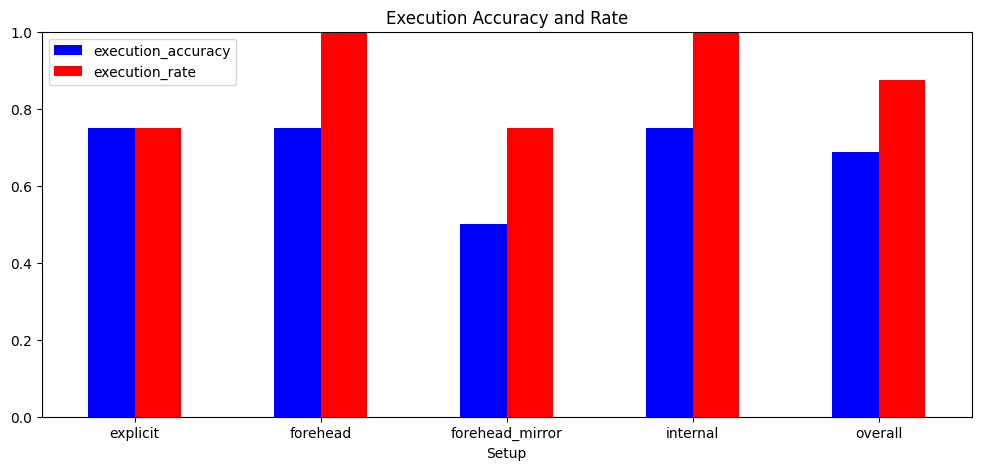

In [49]:
def plot_execution_acc_and_rate(df: pd.DataFrame):
    df = execution_metrics(df)
    fig, ax = plt.subplots(figsize=(12, 5))
    df.plot(use_index=True, y=list(df.columns), kind='bar', ax=ax, color=['blue', 'red'])
    ax.set_ylim(0, 1)
    plt.xticks(rotation=0)
    plt.title("Execution Accuracy and Rate")
    plt.xlabel("Setup")
    plt.show()


plot_execution_acc_and_rate(samples)

## 2. Results Distribution

In [50]:
def results_distribution(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the results distribution
    :param df: 
    :return: 
    """
    distribution = df.groupby('setup').apply(
        lambda x: x['predicted_label'].value_counts(normalize=True),
        include_groups=False
    )
    overall = df['predicted_label'].value_counts(normalize=True)
    distribution.loc[('overall', 1)] = overall.loc[1]
    distribution.loc[('overall', 0)] = overall.loc[0]
    distribution.loc[('overall', -1)] = overall.loc[-1]

    distribution.sort_index(inplace=True, ascending=False)
    return distribution


results_distribution(samples)

setup            predicted_label
overall           1                 0.5625
                  0                 0.3125
                 -1                 0.1250
internal          1                 0.2500
                  0                 0.7500
forehead_mirror   1                 0.7500
                 -1                 0.2500
forehead          1                 0.7500
                  0                 0.2500
explicit          1                 0.5000
                  0                 0.2500
                 -1                 0.2500
Name: proportion, dtype: float64

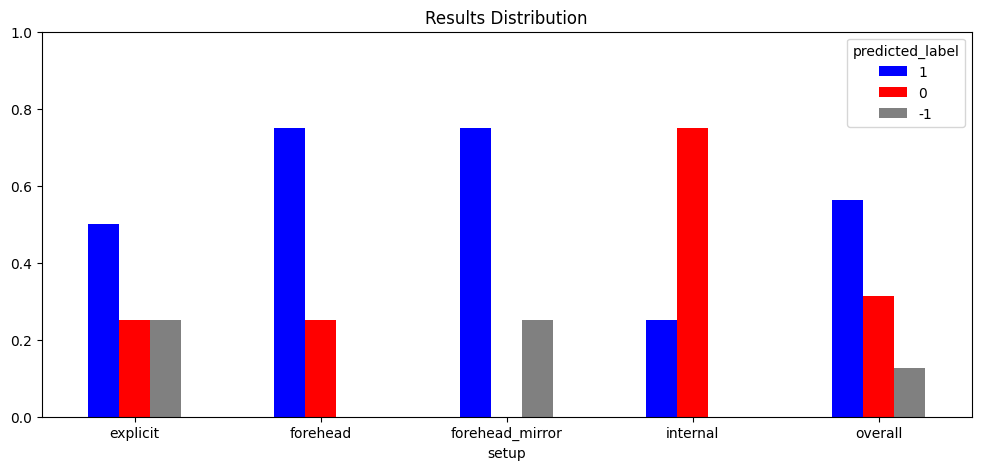

In [51]:
def plot_results_distribution(df: pd.DataFrame):
    df = results_distribution(df)
    fig, ax = plt.subplots(figsize=(12, 5))
    df.unstack().sort_index(axis=1, ascending=False).plot(kind='bar', ax=ax, color=['blue', 'red', 'grey'])
    ax.set_ylim(0, 1)
    plt.xticks(rotation=0)
    plt.title("Results Distribution")
    plt.show()


plot_results_distribution(samples)